<a href="https://colab.research.google.com/github/Baroka-wp/dive_ML/blob/master/Sprint9_Neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
#importer les bibliotheques
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [131]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [132]:
#verification des donnees
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8


(60000, 28, 28)
(10000, 28, 28)
uint8


### Lissage

In [133]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train.shape

(60000, 784)

### Visualisation des données d'image

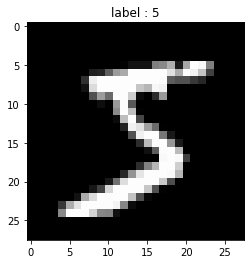

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


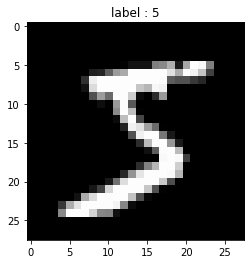

In [135]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # undefined
image -= 105.35 # undefined
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

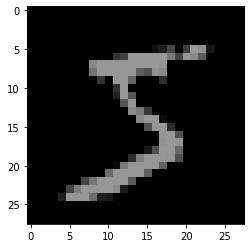

In [136]:
plt.imshow(image, 'gray', vmin = 0, vmax = 250)

## Prétraitement


In [137]:
#normalisation Min Max
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
#spliting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [139]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(48000,)
(48000, 10)
float64


## Scratch réseau de neurones

## Mini traitement par lots



In [140]:
class GetMiniBatch:
    """
    Iterator pour récupérer le mini-batch.

    Paramètres.
    ----------
    X : ndarray de la forme suivante, shape (n_samples, n_features)
      Données de formation
    y : ndarray de la forme suivante, shape (n_samples, 1)
      Valeur de la réponse correcte
    batch_size : int
      Taille du lot
    graine : int
      Semence de nombres aléatoires dans NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [141]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch))


2400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## [Problème 1] Création d'un code pour déterminer la valeur de poids initiale


In [142]:
n_sample,n_features = X_train.shape
n_nodes1 = 400
n_nodes2 = 200
n_output = 10
sigma = 0.01 # Écart-type de la distribution gaussienne
W1 = sigma * np.random.randn(n_features, n_nodes1)

## [Problème 2] Mise en œuvre de la propagation directe


In [143]:
#initialisation des paramettres
b1 = np.random.randn(1)
b2 = sigma * np.random.randn(1, n_nodes2)
W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
W3 = sigma * np.random.randn(n_nodes2, n_output)
b3 = sigma * np.random.randn(1, n_output)


#Calcul de A1 et Z1 de couche 1
A1 = X_train.dot(W1) + b1
Z1 = 1 / (1 + np.exp(-A1))

#Calcule A2 et Z2 de la couche 2 
A2 = Z1.dot(W2) + b2
Z2 =  1 / (1 + np.exp(-A2))

#Calcule A3 et Z3 de la couche 3 
A3 = Z2.dot(W3) + b3
Z3 =  np.exp(A3) / np.sum(np.exp(A3), axis=1).reshape(-1, 1)


## [Problème 3] Implémentation d'une erreur d'entropie croisée


In [144]:
L = -np.sum([y_train[i]*np.log2(Z3[i]) for i in range(len(y_train))])


## [Problème 4] Mise en œuvre de la rétropropagation


C'est la partie qui effectue la descente de gradient stochastique.

## [Problème 5] Estimation


## [Problème 6] Apprentissage et estimation


In [145]:
class ScratchSimpleNeuralNetrowkClassifier():

    def __init__(self, verbose = True, n_features=784,n_nodes1=400,n_nodes2=200, batch_size=20,n_output=10, n_epoch=30, lr=0.01, sigma=0.02):
        self.verbose = verbose
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.batch_size = batch_size
        self.n_output = n_output
        self.n_epoch = n_epoch
        self.lr = lr
        self.sigma = sigma
        self.loss = []
        self.val_loss = []

        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.W3 = None
        self.b3 = None
        pass
    
    def fit(self, X, y, X_val=None, y_val=None):
      self.create_init_w_b()
      for epoch in tqdm(range(self.n_epoch)):
          get_mini_batch = GetMiniBatch(X, y, self.batch_size)
          for mini_X_train, mini_y_train in get_mini_batch: 
            # forward propagation
            self.forward_propagation(mini_X_train)
            self.back_propagation(mini_X_train, mini_y_train)
          self.forward_propagation(X)
          self.loss.append(self.cross_entropy_error(y, self.layer_3))
          if X_val is not None:
              self.forward_propagation(X_val)
              self.val_loss.append(self.cross_entropy_error(y_val, self.layer_3))

      if self.verbose:
          # When verbose is set to True, the learning process etc. is output.
          print(self.loss)
      pass
    
    def create_init_w_b(self):
      self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
      self.b1 = self.sigma * np.random.randn(1, self.n_nodes1)
      self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
      self.b2 = self.sigma * np.random.randn(1, self.n_nodes2)
      self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
      self.b3 = self.sigma * np.random.randn(1, self.n_output)
    
    def activation_function(self,X, layer):
      if layer == "hidden" or layer == "first":
        act_f = np.tanh(X)
        return act_f
      else: 
        act_f = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
        return act_f

    def cross_entropy_error(self, y, Z):
      return -np.sum([y[i]*np.log2(Z[i]) for i in range(len(y))])

    def forward_propagation(self,X):
        self.layer_1_pre = np.matmul(X,self.W1) + self.b1
        self.layer_1 = self.activation_function(self.layer_1_pre, "first")

        self.layer_2_pre = np.matmul(self.layer_1,self.W2) + self.b2
        self.layer_2 = self.activation_function(self.layer_2_pre, "hidden")

        self.layer_3_pre = np.matmul(self.layer_2,self.W3) + self.b3
        self.layer_3 = self.activation_function(self.layer_3_pre, "output")
        
    def back_propagation(self, X, y):
      dA3 = self.layer_3 - y
      dB3 = np.sum(dA3, axis=0)
      dW3 = self.layer_2.T @ dA3
      dZ2 = dA3 @ self.W3.T
      dA2 = dZ2 * (1 - self.activation_function(self.layer_2_pre, "hidden")**2)
      dB2 = np.sum(dA2, axis=0)
      dW2 = self.layer_1.T @ dA2
      dZ1 = dA2 @ self.W2.T
      dA1 = dZ1 * (1 - self.activation_function(self.layer_1_pre, "first")**2)
      dB1 = np.sum(dA1, axis=0)
      dW1 = X.T @ dA1
      self.W3 -= self.lr * dW3
      self.b3 -= self.lr * dB3
      self.W2 -= self.lr * dW2
      self.b2 -= self.lr * dB2
      self.W1 -= self.lr * dW1
      self.b1 -= self.lr * dB1

    def predict(self, X):
      self.forward_propagation(X)
      return np.argmax(self.layer_3, axis=1)


In [146]:
model = ScratchSimpleNeuralNetrowkClassifier()
model.fit(X_train,y_train_one_hot,X_val,y_test_one_hot)


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 30/30 [09:50<00:00, 19.68s/it]

[13891.174573223354, 7960.745942590765, 5886.272672135903, 4027.587971291292, 2931.6306374941396, 2398.0521551896386, 1774.884861081941, 1689.6747536400949, 787.7936976582803, 607.1236690606041, 304.54228274170555, 264.95255675488283, 134.39647427944712, 89.4038433269745, 65.98019584945924, 53.74362625781456, 46.1294714080664, 40.66013078497233, 36.45646013367024, 33.09430877811417, 30.327912769548405, 28.002689797807818, 26.01542391957615, 24.29408100690932, 22.786586145868693, 21.454182444123862, 20.26730868377037, 19.202940557616266, 18.24281986076328, 17.37224167738159]


#### Estimation

In [147]:
y_pred = model.predict(X_val)
print(accuracy_score(y_val, y_pred))


0.9801666666666666


### [Problème 7] Tracé de la courbe d'apprentissage


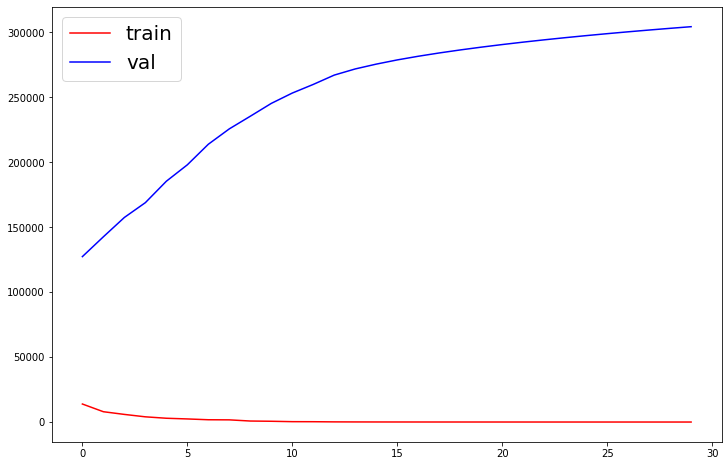

In [148]:
fig = plt.subplots(figsize=(12,8))
plt.rcParams["font.size"] = 20

plt.plot(model.loss,'r', label="train")
plt.plot(model.val_loss,'b', label= "val")
plt.legend()

##[Problème 8] ( exercices avancée) Confirmation d'une classification erronée


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


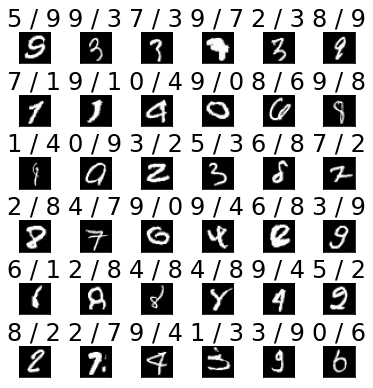

In [149]:
"""
Les résultats de la classification des mots sont affichés côte à côte. L'affichage au-dessus de l'image est "Résultat de l'estimation/réponse correcte".

Paramètres :
----------
y_pred : ndarray d'estimations (n_samples,)
y_val : étiquettes correctes pour les données de validation (n_échantillons,)
X_val : caractéristiques des données de validation (n_samples, n_features)
"""
num = 36 # Combien en afficher.

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')